In [12]:
import os

from pyimagesearch.helpers import convert_and_trim_bb
import argparse
import imutils
import time
import dlib
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def parse_wider_annotations(
    annotation_file: str, base_image_path: str, limit: int = 100
):
    with open(annotation_file, "r") as f:
        lines = f.readlines()

    dataset = []
    i = 0
    while i < len(lines) and len(dataset) < limit:
        filename = lines[i].strip()
        i += 1
        face_count = int(lines[i].strip())
        i += 1
        boxes = []
        for _ in range(face_count):
            x, y, w, h, *_ = map(float, lines[i].strip().split())
            boxes.append((x, y, w, h))
            i += 1

        full_path = os.path.join(base_image_path, filename)
        dataset.append((full_path, boxes))
    return dataset

In [3]:
limit = 100
width = 300

model = "mmod_human_face_detector.dat"
upsample = 1
cnn_detector = dlib.cnn_face_detection_model_v1(model)
hog_detector = dlib.get_frontal_face_detector()

In [4]:
annotation_file = "images/wider_face_split/wider_face_val_bbx_gt.txt"
image_base = "images/WIDER_val/images"

dataset = parse_wider_annotations(annotation_file, image_base, limit=limit)

progress_bar = tqdm(dataset, desc="Evaluating", unit="img") 

Evaluating:   0%|                                                                                                                                 | 0/100 [00:00<?, ?img/s]

In [5]:
img_csv_path = "images/FDDB copy/FDDB-folds/FDDB-fold-01-ellipseList.csv"
img_csv = pd.read_csv(img_csv_path)
img_path = "images/FDDB copy/originalPics"
img_path_list = []
for path in img_csv["img_path"]:
    img_path_list.append(img_path + path)

Evaluating:   0%|                                                                                                                                 | 0/100 [00:00<?, ?img/s]

In [5]:
def scale_by_width(img, true_boxes, width):
    h_orig, w_orig = img.shape[:2]

    img_resized = imutils.resize(img, width=width)
    h_new, w_new = img_resized.shape[:2]

    scale_x = w_new / w_orig
    scale_y = h_new / h_orig

    scaled_boxes = [
        (x * scale_x, y * scale_y, w * scale_x, h * scale_y)
        for (x, y, w, h) in true_boxes
    ]

    return img_resized, scaled_boxes

In [6]:
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    unionArea = boxAArea + boxBArea - interArea

    return interArea / unionArea if unionArea != 0 else 0

In [7]:
def compute_recall(predicted_boxes, true_boxes, iou_threshold=0.5):
    matched = set()
    for true_box in true_boxes:
        for pred_box in predicted_boxes:
            if (
                compute_iou(pred_box, true_box) >= iou_threshold
                and true_box not in matched
            ):
                matched.add(true_box)
                break
    TP = len(matched)
    FN = len(true_boxes) - TP
    return TP / (TP + FN) if (TP + FN) > 0 else 0

In [8]:
def compute_precision(predicted_boxes, true_boxes, iou_threshold=0.5):
    matched = set()
    for pred_box in predicted_boxes:
        for true_box in true_boxes:
            if (
                compute_iou(pred_box, true_box) >= iou_threshold
                and true_box not in matched
            ):
                matched.add(true_box)
                break
    TP = len(matched)
    FP = len(predicted_boxes) - TP
    return TP / (TP + FP) if (TP + FP) > 0 else 0

In [9]:
cnn_recall = []
cnn_precision = []
for image_path, true_boxes in progress_bar:
    img = cv2.imread(image_path)
    img, true_boxes = scale_by_width(img, true_boxes, width)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = cnn_detector(rgb, upsample)
    boxes = [convert_and_trim_bb(img, r.rect) for r in results]
    cnn_sub_recall = compute_recall(boxes, true_boxes)
    cnn_sub_precision = compute_precision(boxes, true_boxes)
    cnn_recall.append(cnn_sub_recall)
    cnn_precision.append(cnn_sub_precision)
print("Mean recall:", np.mean(cnn_recall), "Mean precision:", np.mean(cnn_precision))

Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12img/s]

Mean recall: 0.10381161236424394 Mean precision: 0.16


In [10]:
hog_recall = []
hog_precision = []
for image_path, true_boxes in progress_bar:
    img = cv2.imread(image_path)
    img, true_boxes = scale_by_width(img, true_boxes, width)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hog_detector(rgb, upsample)
    boxes = [convert_and_trim_bb(img, r) for r in results]
    sub_hog_recall = compute_recall(boxes, true_boxes)
    sub_hog_precision = compute_precision(boxes, true_boxes)
    hog_recall.append(sub_hog_recall)
    hog_precision.append(sub_hog_precision)
print("Mean recall:", np.mean(hog_recall), "Mean precision:", np.mean(hog_precision))

Mean recall: 0.06716666666666667 Mean precision: 0.1


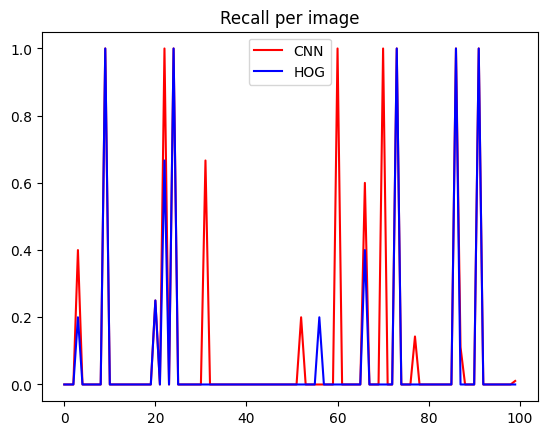

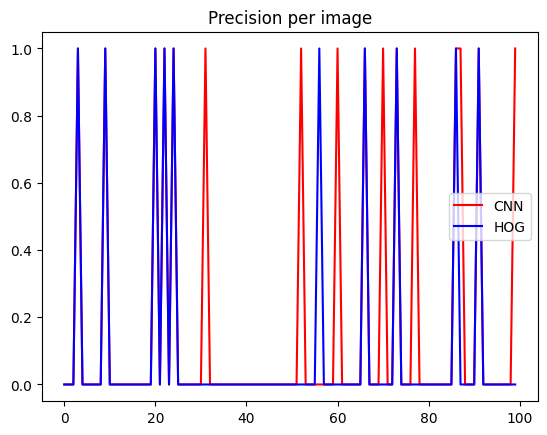

NameError: name 'cnn_speed' is not defined

In [15]:
plt.plot(cnn_recall, color="r", label="CNN")
plt.plot(hog_recall, color="b", label="HOG")
plt.title("Recall per image")
plt.legend(loc="best")
plt.show()

plt.plot(cnn_precision, color="r", label="CNN")
plt.plot(hog_precision, color="b", label="HOG")
plt.title("Precision per image")
plt.legend(loc="best")
plt.show()

plt.plot(cnn_speed, color="r", label="CNN")
plt.plot(hog_speed, color="b", label="HOG")
plt.title("Metapixels speed per image")
plt.legend(loc="best")
plt.show()

In [28]:
idx = np.random.choice(len(dataset), size=5)

In [39]:
idx = np.random.choice(len(dataset), size=5)
filenames = [dataset[i][0] for i in idx]
boxes = [dataset[i][1] for i in idx]
subset_dataset = [(f, b) for f,b in zip(filenames, boxes)]

In [ ]:
dataset

In [41]:
dataset

[('images/WIDER_val/images/0--Parade/0_Parade_marchingband_1_465.jpg',
  [(345.0, 211.0, 4.0, 4.0),
   (331.0, 126.0, 3.0, 3.0),
   (250.0, 126.0, 3.0, 4.0),
   (221.0, 128.0, 4.0, 5.0),
   (427.0, 116.0, 3.0, 4.0),
   (393.0, 79.0, 3.0, 4.0),
   (373.0, 119.0, 3.0, 4.0),
   (90.0, 225.0, 6.0, 5.0),
   (128.0, 237.0, 5.0, 8.0),
   (170.0, 230.0, 5.0, 6.0),
   (114.0, 285.0, 5.0, 7.0),
   (81.0, 304.0, 9.0, 9.0),
   (44.0, 303.0, 10.0, 8.0),
   (7.0, 264.0, 6.0, 8.0),
   (31.0, 231.0, 5.0, 6.0),
   (26.0, 192.0, 6.0, 8.0),
   (66.0, 196.0, 4.0, 6.0),
   (74.0, 175.0, 5.0, 5.0),
   (113.0, 168.0, 4.0, 5.0),
   (129.0, 165.0, 4.0, 5.0),
   (158.0, 162.0, 4.0, 4.0),
   (174.0, 156.0, 5.0, 6.0),
   (197.0, 159.0, 4.0, 4.0),
   (192.0, 191.0, 3.0, 5.0),
   (242.0, 179.0, 5.0, 6.0),
   (161.0, 269.0, 5.0, 6.0),
   (0.0, 317.0, 3.0, 8.0),
   (346.0, 68.0, 3.0, 4.0),
   (418.0, 62.0, 2.0, 3.0),
   (376.0, 59.0, 3.0, 3.0),
   (120.0, 599.0, 12.0, 17.0),
   (1008.0, 256.0, 6.0, 10.0),
   (853.0, 

In [35]:
filenames = [dataset[i][0] for i in idx]
boxes = [dataset[i][1] for i in idx]

In [36]:
filenames

['images/WIDER_val/images/0--Parade/0_Parade_Parade_0_137.jpg',
 'images/WIDER_val/images/0--Parade/0_Parade_Parade_0_559.jpg',
 'images/WIDER_val/images/0--Parade/0_Parade_marchingband_1_329.jpg',
 'images/WIDER_val/images/0--Parade/0_Parade_Parade_0_247.jpg',
 'images/WIDER_val/images/0--Parade/0_Parade_marchingband_1_695.jpg']

In [37]:
boxes

[[(999.0, 515.0, 14.0, 16.0),
  (963.0, 488.0, 19.0, 21.0),
  (953.0, 462.0, 13.0, 21.0),
  (751.0, 452.0, 13.0, 18.0),
  (716.0, 447.0, 14.0, 21.0),
  (709.0, 355.0, 16.0, 20.0),
  (944.0, 306.0, 15.0, 17.0),
  (932.0, 366.0, 14.0, 22.0),
  (658.0, 450.0, 12.0, 18.0),
  (810.0, 337.0, 14.0, 23.0),
  (905.0, 338.0, 12.0, 16.0),
  (382.0, 453.0, 11.0, 16.0),
  (378.0, 480.0, 13.0, 19.0),
  (254.0, 449.0, 13.0, 17.0),
  (238.0, 471.0, 12.0, 14.0),
  (67.0, 336.0, 32.0, 36.0)],
 [(2.0, 332.0, 28.0, 39.0),
  (177.0, 372.0, 51.0, 48.0),
  (303.0, 280.0, 59.0, 30.0),
  (436.0, 358.0, 61.0, 60.0),
  (519.0, 353.0, 47.0, 51.0),
  (568.0, 322.0, 58.0, 51.0),
  (635.0, 369.0, 52.0, 36.0),
  (748.0, 375.0, 38.0, 30.0),
  (763.0, 317.0, 62.0, 52.0),
  (991.0, 438.0, 33.0, 40.0),
  (472.0, 358.0, 31.0, 45.0)],
 [(80.0, 303.0, 21.0, 19.0),
  (136.0, 315.0, 22.0, 26.0),
  (158.0, 328.0, 19.0, 20.0),
  (192.0, 317.0, 19.0, 18.0),
  (213.0, 344.0, 18.0, 18.0),
  (179.0, 394.0, 22.0, 21.0),
  (253.0, 38